In [80]:
import tomopy
import matplotlib.pyplot as plt
import numpy as np
import k3d
import torch
from enum import Enum
# impoer resize 3D image
import tifffile as tiff
import glob
import tqdm
import cv2
from natsort import natsorted
import os
from skimage.exposure import match_histograms
from skimage.transform import resize
from torchmetrics.image import PeakSignalNoiseRatio

def normalize_images(images):
    """
    Normalizes tensor of images 1-channel images between 0 and 1.
    Params:
     - images (torch.Tensor): Tensor of 1-channel images
    """

    image_norm = torch.zeros_like(images)

    for i, image in enumerate(images):

        # print(image.max())
        image = (image - image.mean()) / image.std()
        # image_norm[i, ...] = (image - image.min()) / (image.max() - image.min())
        image_norm[i, ...] = image


    return image_norm
class Order_Modes(Enum):
    Vertical = 0
    Horizontal = 1
def normalize_01(images):
    images = (images- images.min()) / (images.max() - images.min())
    return images
def normalize_mean_std(images, mean=None, std=None):
    if mean is None or std is None:
        mean = images.mean()
        std = images.std()
    images = (images - mean) / std
    return images
def min_max_normalize(image, low_perc=0.05, high_perc=99.05):
    """Main pre-processing function used for the challenge (seems to work the best).
    Remove outliers voxels first, then min-max scale.
    """
    non_zeros = image > 0
    low, high = np.percentile(image[non_zeros], [low_perc, high_perc])
    image = np.clip(image, low, high)
    image = (image - low) / (high - low)
    return image

def flat_field_estimate(img, ratio_corners=0.03):

    height, width = img.shape
    # get corner size as 2% of the  dimension
    corner_size = int(min(height, width) * ratio_corners)

    # Extract the four corner regions (top-left, top-right, bottom-left, bottom-right)
    top_left = img[:corner_size, :corner_size]
    top_right = img[:corner_size, -corner_size:]
    bottom_left = img[-corner_size:, :corner_size]
    bottom_right = img[-corner_size:, -corner_size:]
    middle_left = img[height // 2 - corner_size // 2 : height // 2 + corner_size // 2, :corner_size]
    middle_right = img[height // 2 - corner_size // 2 : height // 2 + corner_size // 2, -corner_size:]
    corner_means = np.array(
        [
            top_left.mean(),
            top_right.mean(),
            bottom_left.mean(),
            bottom_right.mean(),
            middle_left.mean(),
            middle_right.mean(),
        ]
    )
    valid_corners = corner_means[
        (corner_means > np.percentile(corner_means, 10)) & (corner_means < np.percentile(corner_means, 90))
    ]
    flat_field_estimate = valid_corners.mean()

    return flat_field_estimate

In [81]:
from QBI_radon import Radon
import scipy.ndimage as ndi
def resize_sino(sinogram_volume: np.ndarray, order_mode=Order_Modes.Vertical.value, resize_val=100, clip_to_circle=False):
    """
    Resizes sinogram prior to reconstruction.
    Args:
        -sinogram_volume (np.ndarray): array to resize in any mode specified.
    """

    if order_mode == Order_Modes.Vertical.value:
        theta, Q, Z = sinogram_volume.shape
    elif order_mode == Order_Modes.Horizontal.value:
        Q, theta, Z = sinogram_volume.shape

    if clip_to_circle == True:
        sinogram_size = resize_val
    else:
        sinogram_size = int(np.ceil(resize_val * np.sqrt(2)))

    if order_mode == Order_Modes.Vertical.value:

        sinogram_resize = np.zeros((theta, sinogram_size, Z), dtype=np.float32)

    elif order_mode == Order_Modes.Horizontal.value:
        sinogram_resize = np.zeros((sinogram_size, theta, Z), dtype=np.float32)

    for idx in range(Z):

        if order_mode == Order_Modes.Vertical.value:
            sinogram_resize[:, :, idx] = cv2.resize(
                sinogram_volume[:, :, idx],
                (sinogram_size, theta),
                interpolation=cv2.INTER_NEAREST,
            )

        elif order_mode == Order_Modes.Horizontal.value:
            sinogram_resize[:, :, idx] = cv2.resize(
                sinogram_volume[:, :, idx],
                (theta, sinogram_size),
                interpolation=cv2.INTER_NEAREST,
            )

    return sinogram_resize

def fast_reconstruct_FBP(sinogram: np.ndarray, resize_val=None, batch_process=32,device="cpu", rotation_factor=2, order_mode=Order_Modes.Vertical.value, clip_to_circle=False):
    """
    Fast reconstruction function.
    """
    if order_mode == Order_Modes.Vertical.value:
        theta, Q, Z = sinogram.shape
    elif order_mode == Order_Modes.Horizontal.value:
        Q, theta, Z = sinogram.shape
    iradon_functor = Radon(thetas=np.linspace(0, rotation_factor * np.pi, theta, endpoint=False),
                        circle=clip_to_circle,
                        filter_name="ramp",
                        device=device)

    opt_volume = []
    if resize_val is not None:
        sinogram = resize_sino(sinogram, order_mode=order_mode, resize_val=resize_val, clip_to_circle=clip_to_circle)

    if order_mode == Order_Modes.Vertical.value:
        sinogram = sinogram.transpose(1, 0, 2)

    slice_reconstruction = range(Z)
    batch_start = slice_reconstruction[0]
    batch_end = batch_start + batch_process
    while batch_start <= slice_reconstruction[-1]:
        # print("Reconstructing slices {} to {}".format(batch_start, batch_end), end="\r")
        zidx = slice(batch_start, batch_end)
        sino_batch = sinogram[:, :, zidx]
        sino_batch = sino_batch.transpose(2, 0, 1)

        sino_batch = torch.from_numpy(sino_batch[:, None, :, :]).to(device)
        reconstruction = iradon_functor.filter_backprojection(sino_batch)
        # reconstruction = normalize_images(reconstruction)
        reconstruction = reconstruction.permute(1, 2, 3, 0)[0].cpu()
        reconstruction = np.asarray(reconstruction.numpy())
        opt_volume.append(reconstruction)
        batch_start = batch_end
        batch_end += batch_process
    opt_volume = np.concatenate(opt_volume, axis=-1)
    opt_volume = np.rollaxis(opt_volume, -1)
    return opt_volume


def find_center_shift(sinogram: np.ndarray, type_sino="3D", resize_val=None, order_mode=Order_Modes.Vertical.value, clip_to_circle=False, device="cpu"):
    """
    Corrects rotation axis by finding optimal registration via maximising reconstructed image's intensity variance.

    Based on 'Walls, J. R., Sled, J. G., Sharpe, J., & Henkelman, R. M. (2005). Correction of artefacts in optical projection tomography. Physics in Medicine & Biology, 50(19), 4645.'

    Params:
    - sinogram
    """

    if resize_val is not None:
        sinogram = resize_sino(sinogram, order_mode=order_mode, resize_val=resize_val, clip_to_circle=clip_to_circle)
        
    if order_mode == Order_Modes.Vertical.value:
        theta, Q, Z = sinogram.shape
    elif order_mode == Order_Modes.Horizontal.value:
        Q, theta, Z = sinogram.shape
    
    # max_shift is the number of pixels to shift, take 20 pecent of the sinogram size
    max_shift = min(int(Q * 0.1), 200)
    shift_step = min(int(max_shift * 0.05), 9) + 1
    center_shift = 0
    # take only xx percent slices from sinogram from the center
    number_slices = int(Z * 0.2)
    print("max_shift: ", max_shift, "shift_step: ", shift_step, "number_slices: ", number_slices)
    sino_center = sinogram[:, :, Z//2-number_slices//2:Z//2+number_slices//2]
    # calculate batch_process base on theta x Q size for optimizing GPU resource 
    # should be the power of 2 nearest to the result of 1073741 / (theta * Q) with int 
    batch_process = 2**int((np.log2(1073741 / (theta * Q))))
    print("batch_process: ", batch_process)
    while shift_step >= 1:
        shifts = np.arange(-max_shift, max_shift, shift_step) + center_shift
        image_std = []
        for shift in tqdm.tqdm(shifts):
            if order_mode == Order_Modes.Vertical.value and type_sino == "3D":
                shift_tuple = (0, shift, 0)
            elif order_mode == Order_Modes.Horizontal.value or type_sino == "2D":
                shift_tuple = (shift, 0, 0)

            sino_shift = ndi.shift(sino_center, shift_tuple, mode="nearest")

            # Get image reconstruction
            shift_iradon = fast_reconstruct_FBP(sino_shift, device=device, rotation_factor=2, order_mode=order_mode, clip_to_circle=False, batch_process=batch_process)

            # Calculate variance
            image_std.append(np.std(shift_iradon))

        # Update shifts
        center_shift = shifts[np.argmax(image_std)]
        max_shift /= 4
        shift_step /= 2
        print("center_shift: ", center_shift, "max_shift: ", max_shift, "shift_step: ", shift_step)
        if order_mode == Order_Modes.Vertical.value and type_sino == "3D":
            sinogram = ndi.shift(sinogram, (0, center_shift, 0), mode="nearest")
        elif order_mode == Order_Modes.Horizontal.value or type_sino == "2D":
            sinogram = ndi.shift(sinogram, (center_shift, 0, 0), mode="nearest")

    return sinogram

In [82]:
from PIL import Image
list_path = natsorted(glob.glob("datasets/grayscale images/*jpg"))
sino = []
for path in list_path:
    # read image with Image.open
    img = Image.open(path)
    sino.append(np.array(img))
sino = np.stack(sino)
sino = np.moveaxis(sino, 1, 2)
recon = fast_reconstruct_FBP(sino, resize_val=256, device="cuda", rotation_factor=2, order_mode=Order_Modes.Vertical.value)

In [83]:
sino_center = find_center_shift(sino, resize_val=256, type_sino="3D", order_mode=Order_Modes.Vertical.value, device="cuda")

max_shift:  36 shift_step:  2 number_slices:  96
batch_process:  16


100%|██████████| 36/36 [00:27<00:00,  1.31it/s]


center_shift:  -6 max_shift:  9.0 shift_step:  1.0


100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


center_shift:  -5.0 max_shift:  2.25 shift_step:  0.5


In [84]:
recon2 = fast_reconstruct_FBP(sino_center, resize_val=256, device="cuda", rotation_factor=2, order_mode=Order_Modes.Vertical.value)


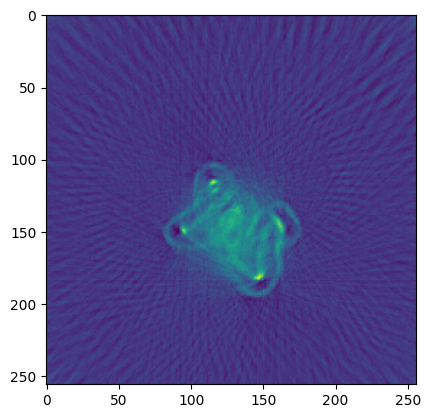

In [85]:
plt.imshow(recon[200])

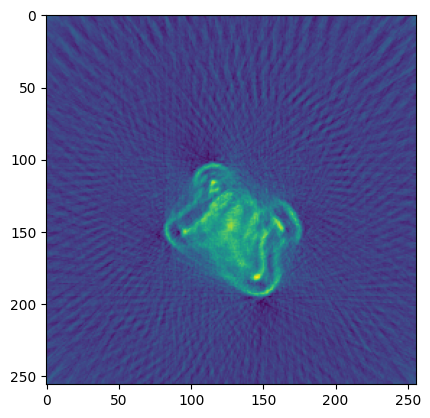

In [86]:
plt.imshow(recon2[200])

In [88]:
# save reconstruction to tiff
tiff.imwrite("reconstruction.tiff", recon)


# save reconstruction to tiff
tiff.imwrite("reconstruction_center.tiff", recon2)

In [ ]:
list_path = natsorted(glob.glob("datasets/raw_data/2024_08_01-transmission/2024_08_01-11-45-31_tr_400/*.tiff"))
os.makedirs("datasets/david_data_preprocessed_10x", exist_ok=True)
for image_path in tqdm.tqdm(list_path[::1]):
    image = tiff.imread(image_path)
    # write image to tif file
    tiff.imwrite(image_path.replace("2025_07_10-12-23-16", "2025_07_10-12-23-16_10x"), image)
    # break


In [ ]:
plt.imshow(image)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import k3d
import torch
# impoer resize 3D image
import tifffile as tiff
import glob
import tqdm
from natsort import natsorted
import os
from skimage.exposure import match_histograms
from skimage.transform import resize
from skimage import exposure
def normalize_01(images):
    images = (images- images.min()) / (images.max() - images.min())

    return images
ctf3 = natsorted(glob.glob("datasets/ctf3/*.tif"))
os.makedirs("datasets/stitched_2X_acc30x", exist_ok=True)
for image_path1 in tqdm.tqdm(ctf3[::30]):
    image1 = tiff.imread(image_path1)
    image2 = tiff.imread(image_path1.replace("ctf3", "ctf2"))
    image3 = tiff.imread(image_path1.replace("ctf3", "ctf1"))
    # increase the contrast by skimage
    # image1 = exposure.equalize_adapthist(image1, clip_limit=0.03)
    # image2 = exposure.equalize_adapthist(image2, clip_limit=0.03)
    # image3 = exposure.equalize_adapthist(image3, clip_limit=0.03)
    image2 = match_histograms(image2, image1, channel_axis=-1)
    image3 = match_histograms(image3, image1, channel_axis=-1)

    y_offset = 0
    img_height = image1.shape[0]
    stitched_image = np.zeros((img_height * 3, image1.shape[1]))
    x, y = 650, 700
    for i, img in enumerate([image1, image2, image3]):

        # stitched_image[y_offset:y_offset+img_height, :] = 0
        stitched_image[y_offset : y_offset + img_height, :] = img

        if i == 0:
            y_offset += img_height - x

        if i == 1:
            y_offset += img_height - y

    stitched_image = stitched_image[80 : -x - y - 450, :]

    # stitched_image = stitched_image - flat_field_estimate(stitched_image)
    # downscale the image to 1/2
    stitched_image = resize(stitched_image, (stitched_image.shape[0] // 2, stitched_image.shape[1] // 2), anti_aliasing=True)
    stitched_image = normalize_01(stitched_image)
    stitched_image = exposure.equalize_adapthist(stitched_image, clip_limit=0.04)
    stitched_image = stitched_image.max() - stitched_image
    stitched_image = normalize_01(stitched_image)
    # convert to 16 bit
    stitched_image = (stitched_image * 65535).astype(np.uint16, copy=False)
    tiff.imsave(image_path1.replace("ctf3", "stitched_2X_acc30x"), stitched_image)
    break

In [ ]:
plt.imshow(stitched_image, cmap="gray")

In [ ]:
# get sinogram from the folder
data_path = natsorted(glob.glob("datasets/stitched_2X_acc10x/*.tif"))
sinogram = []
for image_path in tqdm.tqdm(data_path):
    # read the image
    image = tiff.imread(image_path)
    sinogram.append(image)

sinogram = np.array(sinogram)
sinogram = sinogram.astype(np.float32, copy=False)
sinogram = sinogram / 65535.0


In [ ]:
a = tiff.imread("/home/nhattm/ToMoDL/sinos_slice(200, 201, None).tif")
plt.imshow(a, cmap="gray")

In [ ]:
image1 = tiff.imread("datasets/ctf3/0001.tif")
image2 = tiff.imread("datasets/ctf2/0001.tif")
image3 = tiff.imread("datasets/ctf1/0001.tif")
print(np.max(image2), np.min(image2))
image2 = match_histograms(image2, image1, channel_axis=-1)
print(np.max(image2), np.min(image2))

image3 = match_histograms(image3, image1, channel_axis=-1)
y_offset = 0
img_height = image1.shape[0]
stitched_image = np.zeros((img_height*3, image1.shape[1]))
x, y = 650, 700
for i, img in enumerate([image1, image2, image3]):

    # stitched_image[y_offset:y_offset+img_height, :] = 0
    stitched_image[y_offset:y_offset+img_height, :] = img

    if i == 0:
        y_offset += img_height-x

    if i == 1:
        y_offset += img_height-y

stitched_image = stitched_image[100:-x-y-450, :]
stitched_image = stitched_image / flat_field_estimate(stitched_image)
stitched_image = normalize_01(stitched_image)

In [ ]:
a1 = tiff.imread("datasets/ctf3/0001.tif")
# a1 = normalize_01(a1)
a2 = tiff.imread("datasets/ctf2/0001.tif")
# a2 = normalize_01(a2)
a3 = tiff.imread("datasets/ctf1/0001.tif")
# a3 = normalize_01(a3)
# merge 3 images in x axis
a = np.concatenate((a1,a2,a3),axis=0)

In [ ]:
image1 = tiff.imread("datasets/ctf3/0001.tif")
image2 = tiff.imread("datasets/ctf2/0001.tif")
image3 = tiff.imread("datasets/ctf1/0001.tif")
print(np.max(image2), np.min(image2))
image2 = match_histograms(image2, image1, channel_axis=-1)
print(np.max(image2), np.min(image2))

image3 = match_histograms(image3, image1, channel_axis=-1)
y_offset = 0
img_height = image1.shape[0]
stitched_image = np.zeros((img_height*3, image1.shape[1]))
x, y = 650, 700
for i, img in enumerate([image1, image2, image3]):

    # stitched_image[y_offset:y_offset+img_height, :] = 0
    stitched_image[y_offset:y_offset+img_height, :] = img

    if i == 0:
        y_offset += img_height-x

    if i == 1:
        y_offset += img_height-y

stitched_image = stitched_image[100:-x-y-450, :]
stitched_image = stitched_image / flat_field_estimate(stitched_image)
stitched_image = normalize_01(stitched_image)
figure = plt.figure(figsize=(10, 10))
plt.imshow(stitched_image)

In [ ]:
stitched_image.min(), stitched_image.max()

In [ ]:
stitched_image = stitched_image / flat_field_estimate(stitched_image)
stitched_image = normalize_01(stitched_image)
figure = plt.figure(figsize=(10, 10))
plt.imshow(stitched_image)

In [ ]:
# read tif file
import tifffile as tiff
import glob
import tqdm
import os
import cv2
os.makedirs("/home/nhattm/ToMoDL/datasets/ctf1_cut_10x", exist_ok=True)
resize_factor = 2
file_names = natsorted(glob.glob("/home/nhattm/ToMoDL/datasets/ctf1/*.tif"))
sinos = []
for file_name in tqdm.tqdm(file_names[::10]):
    sino = tiff.imread(file_name)
    sino = np.asarray(sino)[:1600]
    sino = sino.astype(np.float32)
    # sino = sino[:1700, :]
    # sino = cv2.resize(sino, (sino.shape[1]//resize_factor, sino.shape[0]//resize_factor))
    # sino = resize(sino, (sino.shape[0]//resize_factor, sino.shape[1]//resize_factor), anti_aliasing=True)
    tiff.imwrite(f"/home/nhattm/ToMoDL/datasets/ctf1_cut_10x/{file_name.split('/')[-1]}", sino)
    sinos.append(sino)

sinos = np.stack(sinos)

In [ ]:
flat.min(), flat.max()

In [ ]:
def flat_field_correction(image, flat_field, dark_field):
    """
    Corrects an image using flat field and dark field images.

    Args:
        image (numpy.ndarray): The raw image to be corrected.
        flat_field (numpy.ndarray): The flat field image.
        dark_field (numpy.ndarray): The dark field image.

    Returns:
        numpy.ndarray: The corrected image.
    """

    
    # Correct the flat field and raw image
    corrected_flat = flat_field - dark_field
    corrected_image = image - dark_field

    # Handle potential division by zero
    zero_indices = corrected_flat == 0
    corrected_flat[zero_indices] = 1e-6  # Add a small value to avoid division by zero

    # Normalize the flat field
    median_flat = np.median(corrected_flat)
    normalized_flat = corrected_flat / median_flat

    # Apply flat field correction
    corrected_image = corrected_image / normalized_flat
    # invert the image
    corrected_image = corrected_image.max() - corrected_image
    return corrected_image

In [ ]:
resize_factor = 2
file_names = natsorted(glob.glob("datasets/raw_data/2024_08_01-transmission/2024_08_01-11-45-31_tr_400/*.tiff"))
sinos = []
os.makedirs(f"datasets/david_preprocessed_2024_08_01-11-45-31_tr_400", exist_ok=True)
flat = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-01-01_flat_field.tiff")
dark = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-02-29_dark_field.tiff")
for file_name in tqdm.tqdm(file_names):
    image = tiff.imread(file_name)
    image = np.asarray(image)

    image = flat_field_correction(image, flat, dark)
    image = resize(image, (image.shape[0]//resize_factor, image.shape[1]//resize_factor), anti_aliasing=True)
    sinos.append(image)
    # save as tif file
    tiff.imwrite(f"datasets/david_preprocessed_2024_08_01-11-45-31_tr_400/{file_name.split('/')[-1]}", image)
    # break
sinos = np.stack(sinos)
# sinos = normalize_01(sinos)

plt.imshow(sinos[0, :, :], cmap="gray")

In [ ]:
sinos.shape

In [ ]:
resize_factor = 2
file_names = natsorted(glob.glob("datasets/raw_data/2024_08_01-transmission/2024_08_01-11-48-43_tr_50/*.tiff"))
sinos = []
os.makedirs(f"datasets/david_preprocessed_2024_08_01-11-48-43_tr_50", exist_ok=True)
flat = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-01-01_flat_field.tiff")
dark = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-02-29_dark_field.tiff")
for file_name in tqdm.tqdm(file_names):
    image = tiff.imread(file_name)
    image = np.asarray(image)

    image = flat_field_correction(image, flat, dark)
    image = resize(image, (image.shape[0]//resize_factor, image.shape[1]//resize_factor), anti_aliasing=True)
    sinos.append(image)
    # save as tif file
    tiff.imwrite(f"datasets/david_preprocessed_2024_08_01-11-48-43_tr_50/{file_name.split('/')[-1]}", image)
    # break
sinos = np.stack(sinos)
# sinos = normalize_01(sinos)

plt.imshow(sinos[0, :, :], cmap="gray")

In [ ]:
plt.imshow(sinos[-1, :, :], cmap="gray")


In [ ]:
sinos.min(), sinos.max(), sinos.shape

In [ ]:
# height, width = sinos.shape[1], sinos.shape[2]
# img = sinos[0]

img = stitched_image
height, width = stitched_image.shape[0], stitched_image.shape[1]

corner_size = int(min(height, width) * 0.03)

# Extract the four corner regions (top-left, top-right, bottom-left, bottom-right)
top_left = img[:corner_size, :corner_size]
top_right = img[:corner_size, -corner_size:]
bottom_left = img[-corner_size:, :corner_size]
bottom_right = img[-corner_size:, -corner_size:]
middle_left = img[height//2-corner_size//2:height//2+corner_size//2, :corner_size]
middle_right = img[height//2-corner_size//2:height//2+corner_size//2, -corner_size:]
corner_means = np.array([top_left.mean(), top_right.mean(), bottom_left.mean(), bottom_right.mean(), middle_left.mean(), middle_right.mean()])
valid_corners = corner_means[(corner_means > np.percentile(corner_means, 10)) & (corner_means < np.percentile(corner_means, 90))]
flat_field_estimate = valid_corners.mean()


sinos_normalized = stitched_image / flat_field_estimate
# sinos_normalized = normalize_01(sinos_normalized)
# sinos_normalized = -np.log10(sinos_normalized +1e-4)
sinos_normalized = normalize_01(sinos_normalized)

In [ ]:
flat_field_estimate

In [ ]:
sino2 = sinos / flat_field_estimate
sino2 = normalize_01(sino2)

In [ ]:
sinos_normalized.min(), sinos_normalized.max()

In [ ]:
corner_size = int(min(height, width) * 0.03)

In [ ]:
import matplotlib.patches as patches

# Display the first sinogram
fig, ax = plt.subplots(1)
ax.imshow(sinos[0], cmap="gray")

# Draw rectangles around the corners
rect_top_left = patches.Rectangle((0, 0), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_top_right = patches.Rectangle((width - corner_size, 0), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_bottom_left = patches.Rectangle((0, height - corner_size), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_bottom_right = patches.Rectangle((width - corner_size, height - corner_size), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_middle_left = patches.Rectangle((0, height//2 - corner_size//2), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_middle_right = patches.Rectangle((width - corner_size, height//2 - corner_size//2), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
# Add the rectangles to the plot
ax.add_patch(rect_top_left)
ax.add_patch(rect_top_right)
ax.add_patch(rect_bottom_left)
ax.add_patch(rect_bottom_right)
ax.add_patch(rect_middle_left)
ax.add_patch(rect_middle_right)

plt.show()


In [ ]:
plt.imshow(sinos_normalized, cmap="gray")

In [ ]:
plt.imshow(sinos[0], cmap="gray")

In [ ]:
sinos_normalized.shape

In [ ]:
theta = tomopy.angles(sinos.shape[0])
rot_center = tomopy.find_center(sinos, theta, init=290, ind=0, tol=0.5)
print(rot_center)

In [ ]:

recon = tomopy.recon(sinos, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
rec = tomopy.circ_mask(rec, axis=0, ratio=0.95)
# rec = rec.max() - rec
rec = (rec - rec.min()) / (rec.max() - rec.min())
rec = rec * (2**16 - 1)
rec = rec.astype(np.uint16)
tiff.imwrite("/home/nhattm/david_data.tif", rec)

In [ ]:
rec.min(), rec.max()

In [ ]:
extra_options = {'MinConstraint': 0}
options = {
    # 'proj_type': 'cuda',
    # "filter_name": "ramlak",

    # 'num_iter': 200,
    # 'extra_options': extra_options,
    # "accelerated": True
}
# rec = tomopy.recon(sinos,theta, algorithm="gridrec",filter_name= "ramlak")
batch_size = 1
batch_start = 0
batch_end = batch_start + batch_size
recs = []
while batch_end <= sinos.shape[0]:
    rec = tomopy.recon(sinos[batch_start:batch_end],theta[batch_start:batch_end], algorithm="gridrec",filter_name= "ramlak")
    recs.append(rec)
    batch_end = batch_start + batch_size
    batch_start = batch_end
    
recs = np.stack(recs)